Select "Runtime" -> "Change runtime type"
Change type to "GPU".

In [4]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        2.8G        3.5G        261M        6.3G         10G
Swap:            0B          0B          0B


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import os
os.chdir("/content/gdrive/My Drive/SSD_ADAS/ssd_keras/")
print("Working directory:", os.getcwd())

Working directory: /content/gdrive/My Drive/SSD_ADAS/ssd_keras


In [2]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

Using TensorFlow backend.


In [0]:
img_height = 300
img_width = 300
n_classes = 80 # COCO classes
model_mode = 'training' # Do this even when evaluating.

# 1: Build the Keras model
K.clear_session() # Clear previous models from memory.
model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=n_classes,
                mode=model_mode,
                l2_regularization=0.0005,
                scales= [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05], # COCO
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.
weights_path = '../pretrained_weights/VGG_coco_SSD_300x300_iter_400000.h5'
model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [13]:
# Make datagen

images_dir = '../FLIR_ADAS/validation/PreviewData'
annotation_csv = '../validation.csv'
input_format = ["image_name", "class_id", "xmin", "xmax", "ymin", "ymax"] # order of columns in csv

dataset = DataGenerator(load_images_into_memory=True)
dataset.parse_csv(
    images_dir,
    annotation_csv,
    input_format,
    verbose=True
    )

Loading images into memory: 100%|██████████| 1360/1360 [00:08<00:00, 167.48it/s]


In [0]:
# Create Evaluator instance, caching predictions
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

In [26]:
# Evaluate the cached predictions
results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=64,
                    data_generator_mode='resize',
                    matching_iou_threshold=0.5,
                    average_precision_mode='integrate',
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 1360

Producing predictions batch-wise: 100%|██████████| 22/22 [10:05<00:00, 21.71s/it]
Matching predictions to ground truth, class 1/80.: 100%|██████████| 147778/147778 [00:18<00:00, 8195.78it/s]
Matching predictions to ground truth, class 2/80.: 100%|██████████| 1707/1707 [00:00<00:00, 9861.84it/s]
Matching predictions to ground truth, class 3/80.: 100%|██████████| 84515/84515 [00:10<00:00, 7899.91it/s]
Matching predictions to ground truth, class 4/80.: 100%|██████████| 111/111 [00:00<00:00, 8122.97it/s]
Matching predictions to ground truth, class 5/80.: 100%|██████████| 196/196 [00:00<00:00, 11153.40it/s]
Matching predictions to ground truth, class 6/80.: 100%|██████████| 320/320 [00:00<00:00, 12694.14it/s]
Matching predictions to ground truth, class 7/80.: 100%|██████████| 2222/2222 [00:00<00:00, 30395.99it/s]
Matching predictions to ground truth, class 8/80.: 100%|██████████| 2323/2323 [00:00<00:00, 28584.33it/s]
Matching predictions to 

/content/gdrive/My Drive/SSD_ADAS/ssd_keras/eval_utils/average_precision_evaluator.py:776: RuntimeWarning: invalid value encountered in true_divide
  cumulative_recall = tp / self.num_gt_per_class[class_id] # 1D array with shape `(num_predictions,)`


Computing average precision, class 8/80
Computing average precision, class 9/80
Computing average precision, class 10/80
Computing average precision, class 11/80
Computing average precision, class 12/80
Computing average precision, class 13/80
Computing average precision, class 14/80
Computing average precision, class 15/80
Computing average precision, class 16/80
Computing average precision, class 17/80
Computing average precision, class 18/80
Computing average precision, class 19/80
Computing average precision, class 20/80
Computing average precision, class 21/80
Computing average precision, class 22/80
Computing average precision, class 23/80
Computing average precision, class 24/80
Computing average precision, class 25/80
Computing average precision, class 26/80
Computing average precision, class 27/80
Computing average precision, class 28/80
Computing average precision, class 29/80
Computing average precision, class 30/80
Computing average precision, class 31/80
Computing average 

In [28]:
classes_of_interest = {1:"person", 2:"bicycle", 3:"car", 17:"dog"}

for i in classes_of_interest.keys():
    print("{:<14}{:<6}{}".format(classes_of_interest[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

person        AP    0.112
bicycle       AP    0.022
car           AP    0.252
dog           AP    0.0

              mAP   nan


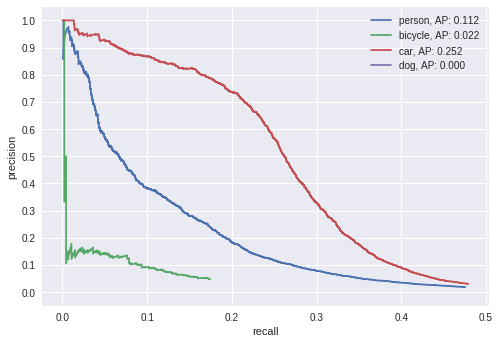

In [57]:
def plot_PR(class_id):
  plt.figure()
  plt.plot(recalls[class_id], precisions[class_id])
  plt.xlabel('recall')
  plt.ylabel('precision')
  plt.xticks(np.linspace(0,1,11))
  plt.yticks(np.linspace(0,1,11))
  plt.title(
      "Class id: {} ({}), AP: {:.3f}".format(class_id, classes_of_interest[class_id], average_precisions[class_id])
  )
  
def plot_PRs(class_ids):
  plt.figure()
  
  for class_id in class_ids:
    plt.plot(
        recalls[class_id],
        precisions[class_id],
        label = "{}, AP: {:.3f}".format(classes_of_interest[class_id], average_precisions[class_id]))
    
  #plt.xlim((0,1))
  #plt.ylim((0,1))
  plt.xticks(np.linspace(0,1,11))
  plt.yticks(np.linspace(0,1,11))
  plt.legend()
  return
    
plot_PRs(classes_of_interest.keys())

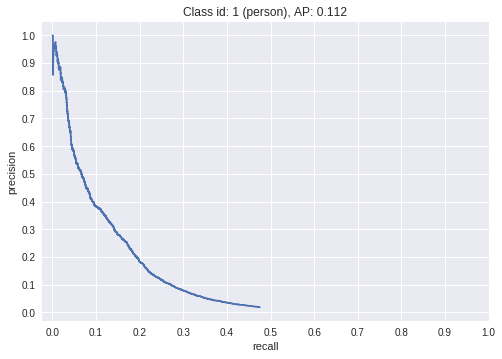

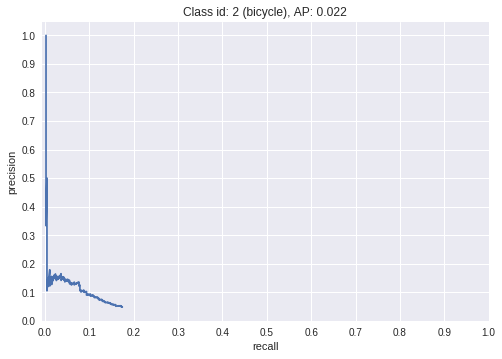

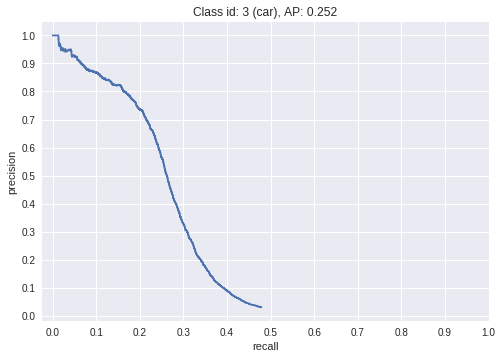

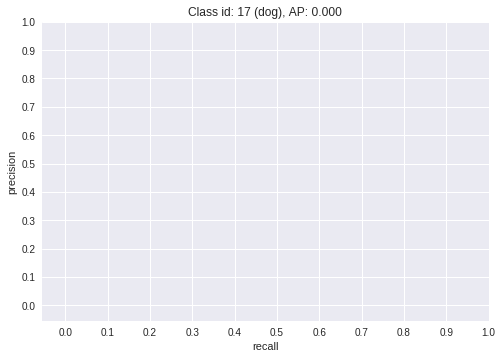

In [51]:
for class_id in classes_of_interest.keys():
  plt.figure()
  plot_PR(class_id)

In [22]:
!df -h /tmp

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G  8.8G  332G   3% /
